# How good are LLMs at doing probabilistic inference (discrete)

The idea is that we pass a bunch of CPTs and we ask the LLM to give us the probability of a specific case.

We then compare the LLM result with that of a Bayesian network.

In [2]:
import sys
from pathlib import Path
from os import getenv

from openai import OpenAI
from pgmpy.utils import get_example_model
from pgmpy.inference import VariableElimination

# Set the base path
base_path = Path("../../")  # One level up from the current working directory

# Add the src/ directory to sys.path using base_path
sys.path.append(str((base_path / "src").resolve()))


from bn_utils import draw_bayesian_network
from inference_discrete import format_probability_query, query_probability
from yaml_utils import load_yaml
from llm_calling import run_llm_call

## Load Bayesian network

In [3]:
# Load the ASIA network example
model = get_example_model("asia")

# Print the model structure (nodes and edges)
# print("Nodes in the network:", model.nodes())
# print("Edges in the network:", model.edges())

# Collect CPDs into a single string
cpd_strings = []
for cpd in model.get_cpds():
    cpd_strings.append(str(cpd))

# Join them with double newlines
cpds_as_string = "\n\n".join(cpd_strings)

# If you want to check
# print(cpds_as_string)

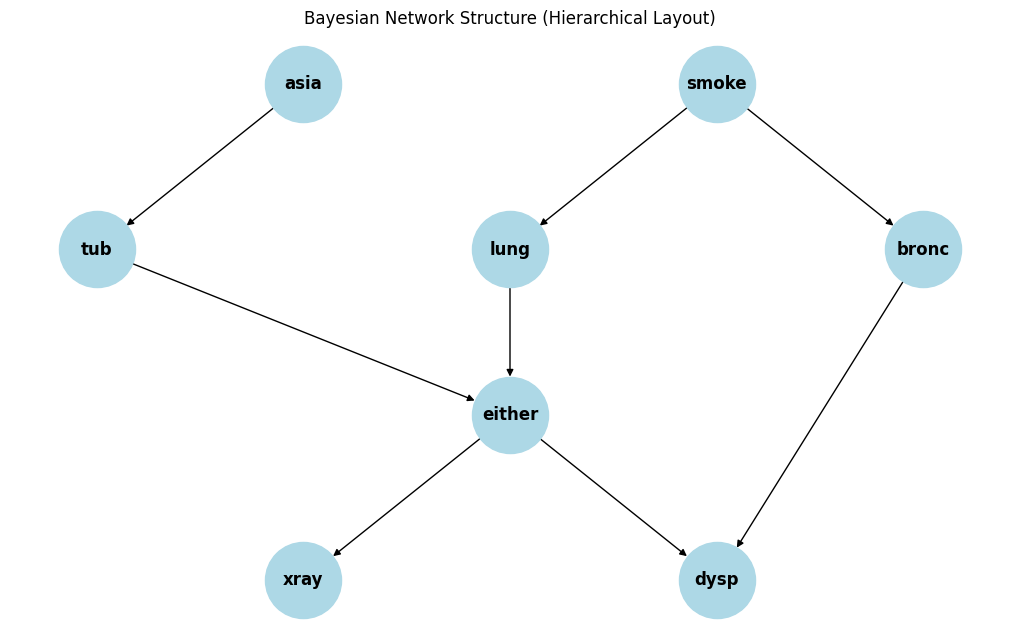

In [4]:
draw_bayesian_network(model)

## Prepare prompt

In [5]:
# Load prompt
prompt_path = base_path / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)

In [6]:
evidence = {'smoke': 'yes', 'asia': 'no', 'tub': 'yes'}
variable = 'dysp'
value = 'no'

query_str = format_probability_query('dysp', 'no', evidence)

prompt_str = prompts["prompt_base"].format(cpts=cpds_as_string, query=query_str)

messages = [
    {"role": "system", "content": prompts["system_prompt"]},
    {"role": "user", "content": prompt_str}
]

print(query_str)

P(dysp=no | smoke=yes, asia=no, tub=yes)


In [12]:
# print(prompts["system_prompt"])
# print(messages[1]["content"])

## Run exact inference

In [13]:
inference_engine = VariableElimination(model)
prob = query_probability(inference_engine, 'dysp', 'no', evidence)
print(f"Result: {prob:.4f}")

Result: 0.1800


## Initialize LLM

In [14]:
# MODEL = "gpt-4o-mini" # To test the baseline performance of LLMs
# MODEL = "deepseek/deepseek-r1" 
# MODEL = "anthropic/claude-3.7-sonnet:thinking"
# MODEL = "google/gemini-2.5-pro-preview"
MODEL = "openai/o3-mini-high"

In [17]:
# Initialize OpenAI client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY")
)

## Run LLM

In [ ]:
response, messages = run_llm_call(
    openai_client=client,
    model=MODEL,
    messages=messages
)

print(response)

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


We wish to compute

  P(dysp = no | smoke = yes, asia = no, tub = yes).

In our network (the “Asia” network) the relevant nodes and their conditional probability tables are as follows:

1. P(asia) is given by:
  P(asia = yes) = 0.01   P(asia = no) = 0.99

2. P(smoke) is marginal with:
  P(smoke = yes) = 0.5   P(smoke = no) = 0.5

3. P(tub | asia) is given by:
  For asia = no, P(tub = yes | asia = no) = 0.01   P(tub = no | asia = no) = 0.99

4. P(bronc | smoke) is given by:
  For smoke = yes, P(bronc = yes | smoke = yes) = 0.6, P(bronc = no | smoke = yes) = 0.4

5. P(lung | smoke) is given by:
  For smoke = yes, P(lung = yes | smoke = yes) = 0.1, P(lung = no | smoke = yes) = 0.9

6. P(either | lung, tub) is defined deterministically: either = yes if at least one of lung or tub is yes and either = no only when both lung and tub are no. Since our evidence includes tub = yes, regardless of lung, we have
  P(either = yes | any lung, tub = yes) = 1.

7. P(dysp | bronc, either) is given by:
 